导入库

In [1]:
from scipy import stats
from scipy.stats import norm, skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

导入数据

Text(0.5, 0, 'GrLivArea')

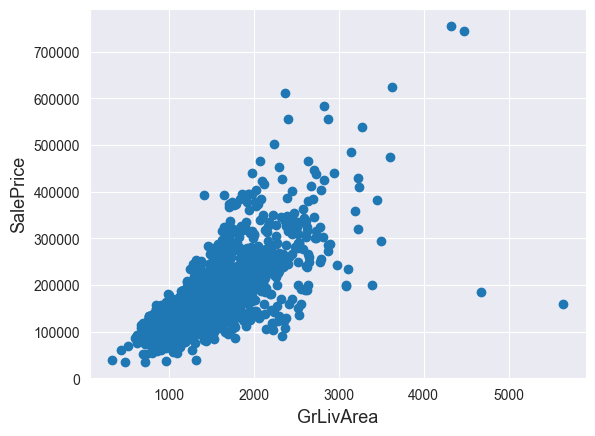

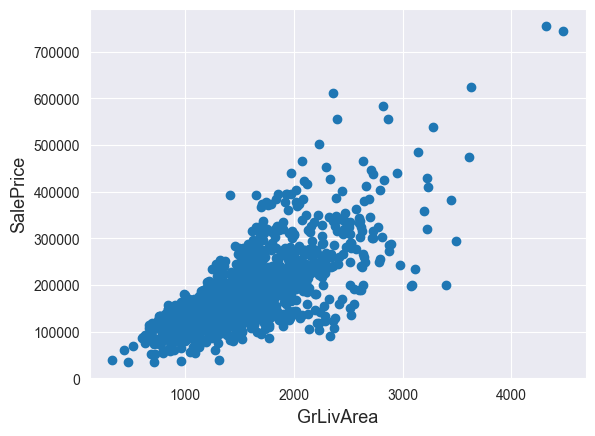

In [2]:
color = sns.color_palette()
sns.set_style('darkgrid')

train = pd.read_csv('E:\\python code\\实验五\\train.csv')
test = pd.read_csv('E:\\python code\\实验五\\test.csv')

fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])

plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

train = train.drop(train[(train['GrLivArea'] > 4000) &
                   (train['SalePrice'] < 300000)].index)
# 处理异常值
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)


 mu = 12.02 and sigma = 0.40



C:\Users\15825\AppData\Local\Temp\ipykernel_36880\3815315929.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], fit=norm)


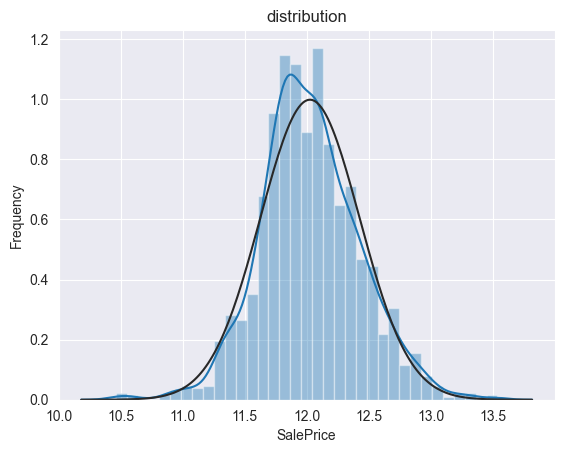

In [3]:
train_ID = train['Id']
test_ID = test['Id']
train["SalePrice"] = np.log1p(train["SalePrice"])  # log变化，调整
# plt.show()
# 绘制分布函数以及分位图（判断是否近似正态分布）
plt.ylabel('Frequency')
plt.title('distribution')
sns.distplot(train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.show()



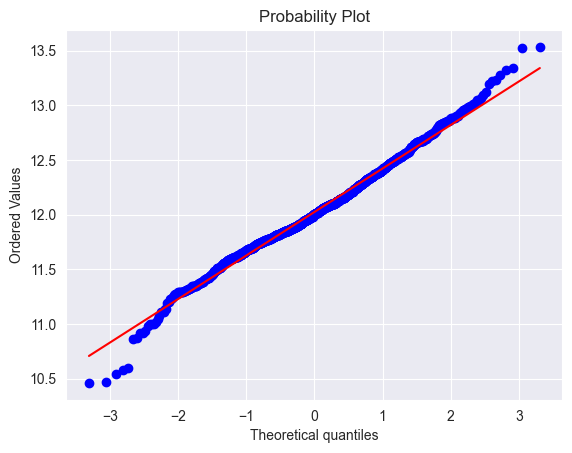

In [4]:

# 绘制分位图
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [5]:
# 缺失值处理
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})

all_data size is : (2917, 80)


Text(0.5, 1.0, 'Percent missing data by feature')

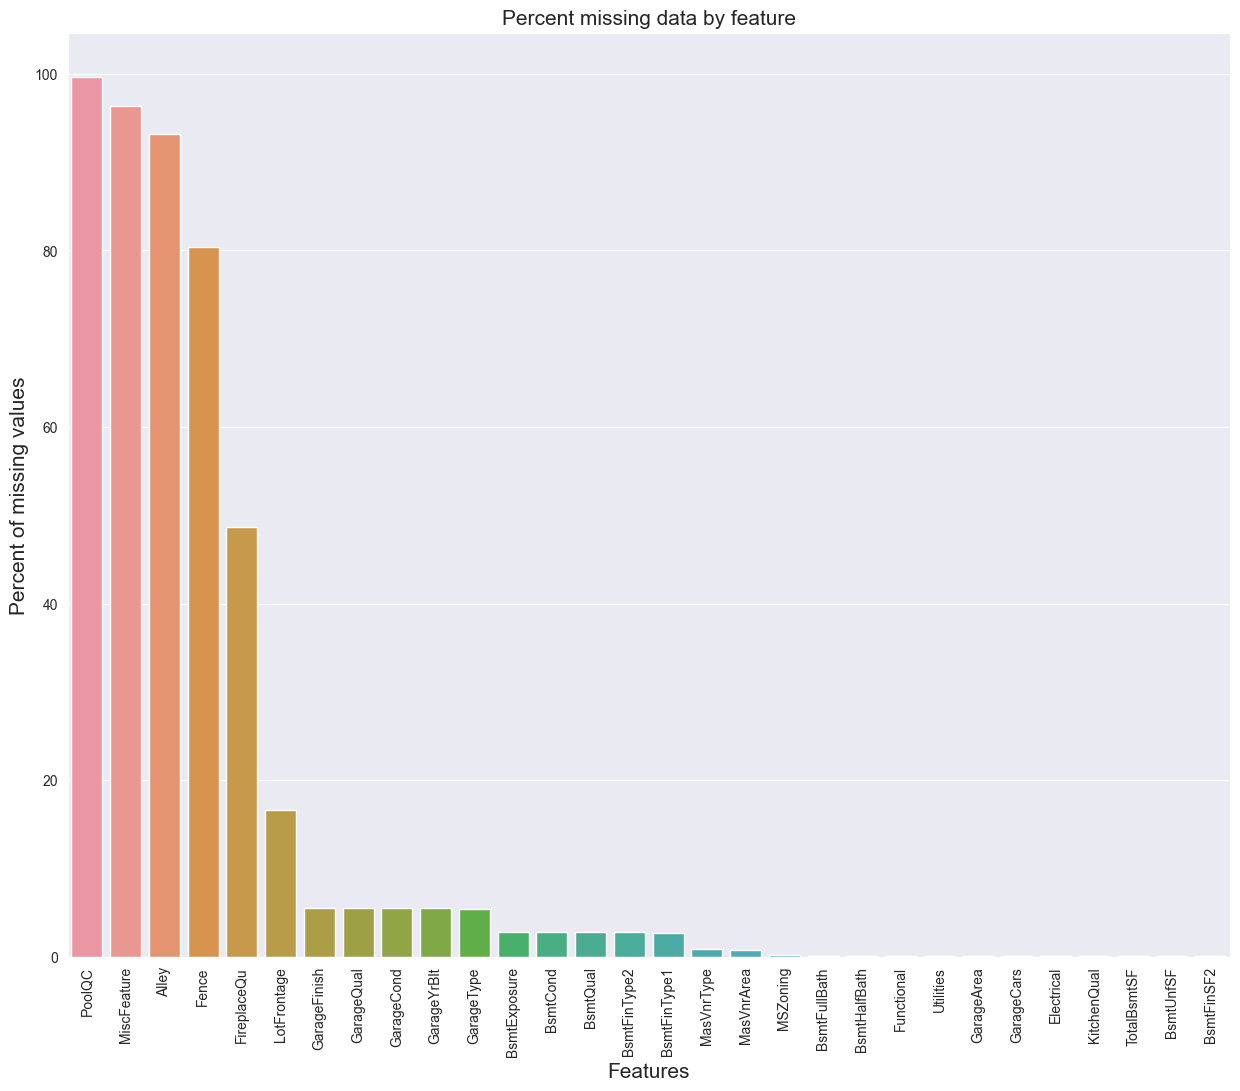

In [6]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [7]:
# 该赋None的
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")  # 泳 池
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")  # 杂 项 功 能
all_data["Alley"] = all_data["Alley"].fillna("None")  # 小 径
all_data["Fence"] = all_data["Fence"].fillna("None")  # 围 栏
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")  # 壁 炉
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):  # 车 库 类 型 等
    all_data[col] = all_data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):  # 地 下 室类 型 等
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")  # 是 否 有 瓷 砖 铺 面
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")  # 建 筑 类 型

# 该赋为0的
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):  # 车 库 面 积 等
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):  # 地 下 室 面 积 等
    all_data[col] = all_data[col].fillna(0)
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)  # 瓷 砖 铺 面 面 积
# 需要插值的
all_data["LotFrontage"] = all_data.groupby(
    "Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
# 很常见，用众数填充
all_data['MSZoning'] = all_data['MSZoning'].fillna(
    all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(
    all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(
    all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(
    all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(
    all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(
    all_data['SaleType'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)  # 没用，删掉
all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
print(missing_data.head())

Empty DataFrame
Columns: [Missing Ratio]
Index: []


<AxesSubplot:>

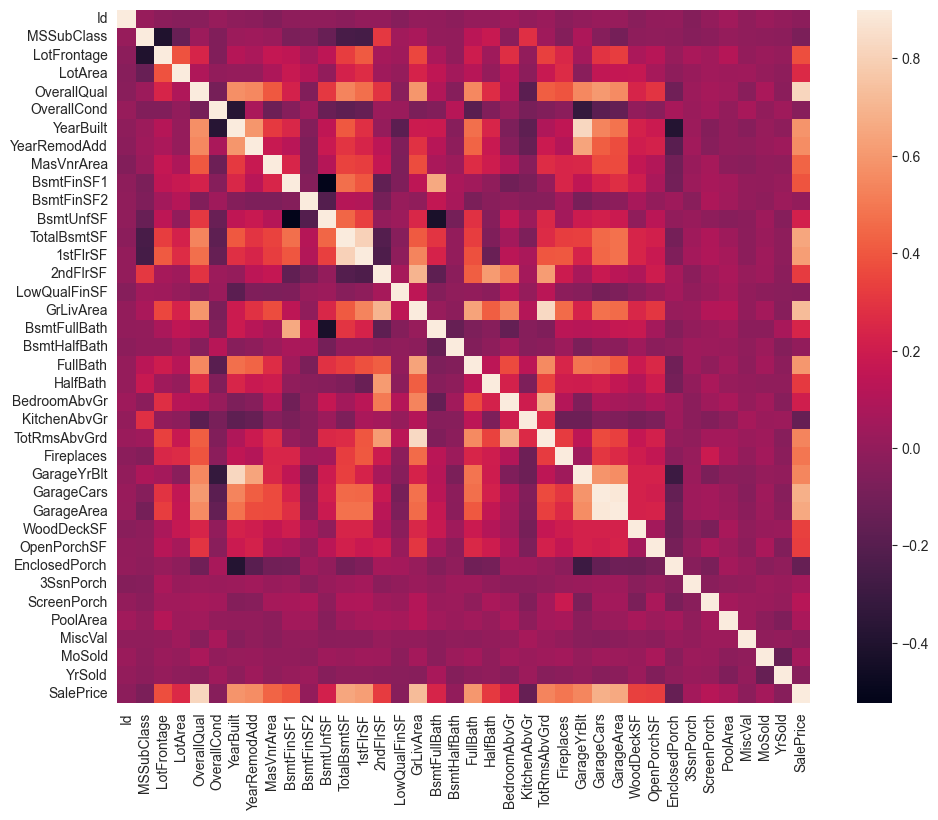

In [8]:
# 相关性系数
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [9]:
# 整合面积
all_data['TotalSF'] = all_data['TotalBsmtSF'] + \
    all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 转化为字符串
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


# 对特征进行编码

In [10]:
# 对特征进行编码

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns , apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))


In [11]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)  # type: ignore
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
print(skewness.head(10))
print("There are {} skewed numerical features to Box Cox transform".format(
    skewness.shape[0]))



Skew in numerical features: 

                    Skew
MiscVal        21.939672
PoolArea       17.688664
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
LandSlope       4.973254
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101
There are 60 skewed numerical features to Box Cox transform


In [12]:
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
print(missing_data.head(50))

# shape
all_data = pd.get_dummies(all_data)
print(all_data.shape)
# (2917 , 220) 这里已经有220维了
print(all_data.head())

# 特征降维
pca = PCA(n_components=100)
all_data_pca = pca.fit_transform(all_data)
print(all_data_pca.shape)
# print('Shape all_data: {}'.format(all_data.shape))

Empty DataFrame
Columns: [Missing Ratio]
Index: []
(2917, 221)
         Id  MSSubClass  LotFrontage    LotArea    Street     Alley  LotShape  \
0  0.730463    2.885846     5.831328  19.212182  0.730463  0.730463  1.540963   
1  1.194318    2.055642     6.221214  19.712205  0.730463  0.730463  1.540963   
2  1.540963    2.885846     5.914940  20.347241  0.730463  0.730463  0.000000   
3  1.820334    3.011340     5.684507  19.691553  0.730463  0.730463  0.000000   
4  2.055642    2.885846     6.314735  21.325160  0.730463  0.730463  0.000000   

   LandSlope  OverallQual  OverallCond  ...  SaleType_ConLw  SaleType_New  \
0        0.0     2.440268     1.820334  ...               0             0   
1        0.0     2.259674     2.440268  ...               0             0   
2        0.0     2.440268     1.820334  ...               0             0   
3        0.0     2.440268     1.820334  ...               0             0   
4        0.0     2.602594     1.820334  ...               0      

In [13]:
# 重新导入特征提取过后的数据
train = all_data[:ntrain]
test = all_data[ntrain:]

In [14]:
# 模型评分函数
n_folds = 5


def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train,
                   scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [15]:
# 五个回归模型
linear = make_pipeline(RobustScaler(), LinearRegression())
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.9, random_state=1))
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(
    alpha=0.0005, l1_ratio=.9, random_state=1))
KRR = KernelRidge(alpha=0.6, kernel='polynomial',  # type: ignore
                  degree=2, coef0=2.5)  # type: ignore
                  
# 回归模型的分数
score = rmsle_cv(linear)
print("\nLinearRregression score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))
# LinearRregression score: 0.1238 (0.0109)
score = rmsle_cv(ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# Ridge score: 0.1185 (0.0099)
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# Lasso score: 0.1115 (0.0074)
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# ElasticNet score: 0.1116 (0.0074)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))
# Kernel Ridge score: 0.1153 (0.0075)


LinearRregression score: 0.1241 (0.0105)


Ridge score: 0.1186 (0.0096)


Lasso score: 0.1115 (0.0074)

ElasticNet score: 0.1116 (0.0074)

Kernel Ridge score: 0.1163 (0.0065)



In [16]:
# 尝试bagging集成学习方法
Bagging = BaggingRegressor(
    base_estimator=LinearRegression(), n_estimators=10, random_state=1)
RandomForest = RandomForestRegressor(n_estimators=100, criterion='mse')
score = rmsle_cv(Bagging)
# 相对应分数
print("Bagging score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# Bagging score: 0.1190 (0.0092)
score = rmsle_cv(RandomForest)
print("RandomForest score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))
# RandomForest score: 0.1447 (0.0054)


Bagging score: 5150353.6195 (10300706.9881)



c:\Users\15825\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\15825\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\15825\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\15825\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` w

RandomForest score: 0.1383 (0.0051)



In [17]:
# 尝试boosting集成学习方法
# 共四种
AdaBoost = AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=50, learning_rate=1.0, loss='linear',
                             random_state=None)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, random_state=7, nthread=-1)
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin=55,
                              bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9,
                              bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
# 一下为各个boosting模型的误差
score = rmsle_cv(AdaBoost)
print("AdaBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# AdaBoost score: 0.1688 (0.0089)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# Gradient Boosting score: 0.1177 (0.0080)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# Xgboost score: 0.1161 (0.0079)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


# LGBM score: 0.1153 (0.0057)

AdaBoost score: 0.1629 (0.0102)

Gradient Boosting score: 0.1161 (0.0078)

[18:27:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:27:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:27:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:27:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[18:27:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/le